## inputs

In [1]:
# path to saved model to be used for SHAP analysis
model_dir = "220924_NN_rand_seed0_ROS"

variants_to_explain = ["KRHWMR", "MRRWMR"]
pam_to_explain = "NGTG"
create_summary_plots = True
save_plots = False # if true plots will be saved in a folder called shap_figs, otherwise just display

## Load info from saved model directory

In [2]:
import shap
import pickle
from functions import *
from tensorflow import keras
import ast
import os
import matplotlib as mpl
import matplotlib.pyplot as plt
import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

if save_plots:
    if not os.path.isdir("./shap_figs"):
        os.mkdir("./shap_figs")

# read in the variables that were used during training
with open(model_dir + "/data_parameters.pkl", 'rb') as file:
    vars = pkl.load(file)
run_name, model_name, three_nt_PAM, test_fraction, LOW_RATE_CONSTANT_CUTOFF, LOW_RATE_REPLACE, \
HEATMAP_MAX, HEATMAP_MIN, nts, all_positions, pams = vars
with open(model_dir + "/mean_std.pkl", 'rb') as file:
    DATA_MEAN, DATA_STD = pkl.load(file)

# load model
model = keras.models.load_model(model_dir + "/saved_model")

train = pd.read_csv(model_dir + "/training_data_norm.csv")
print("TRAIN MEAN ", np.mean(train[pams]))
print("TRAIN STD", np.std(np.array(train[pams]).flatten()))
x_train = train["muts_encoded"]

x_train = np.stack([np.fromstring(x_train[i].strip("[]"), dtype = int, sep = '. ') for i in range(len(x_train))])


Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


TRAIN MEAN  -0.002684225017806034
TRAIN STD 0.9938601017347134


## Encode training data, subsample and create Deep Explainer

In [3]:
# get features & onehot encoding (mutates input df) for the variants we want to explain
muts_df = pd.DataFrame([list(mut) for mut in variants_to_explain], columns=all_positions, index=variants_to_explain)


enc = add_onehot(muts_df, 
                ['D1135', 'S1136', 'G1218','E1219', 'R1335', 'T1337'],
                encoder=None)
aas = add_onehot(muts_df, ['D1135', 'S1136', 'G1218','E1219', 'R1335', 'T1337'], return_aas=True)

feature_names = get_full_feature_names(['D1135', 'S1136', 'G1218','E1219', 'R1335', 'T1337'], [aas for _ in range(6)])


to_explain = np.stack([np.array(element) for element in muts_df["muts_encoded"]])
print(to_explain.shape)

Xsamp = shap.utils.sample(x_train, 100) 

explainer = shap.DeepExplainer(model, Xsamp)




(2, 120)


keras is no longer supported, please use tf.keras instead.
Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.


## Create summary plots for most important features across sampled training examples

`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
2024-07-03 16:34:19.682863: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


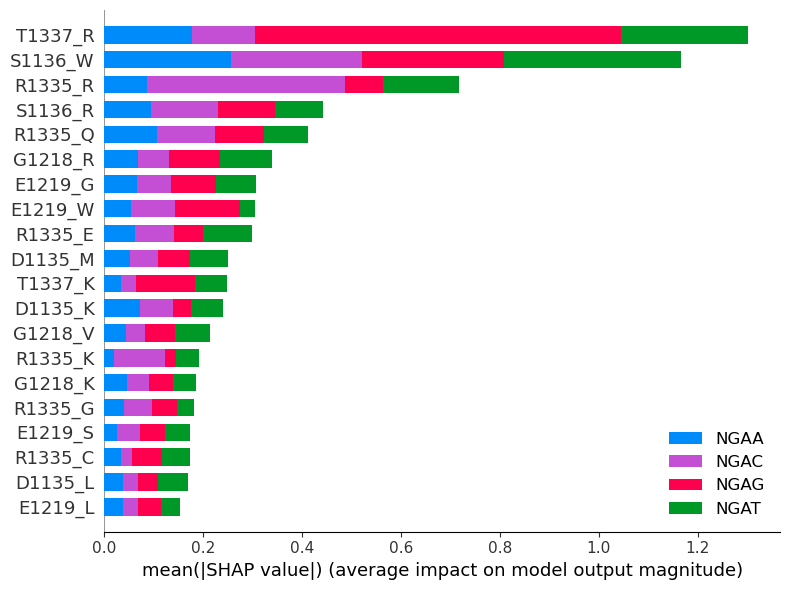

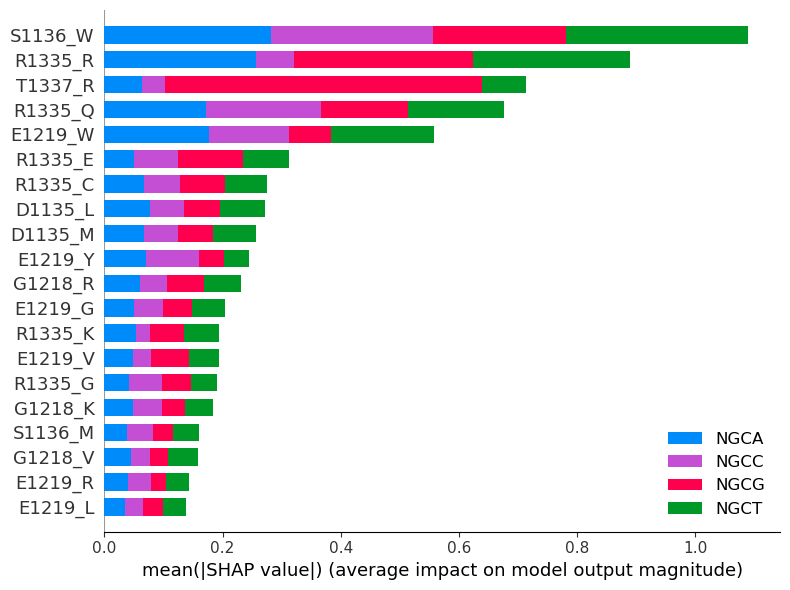

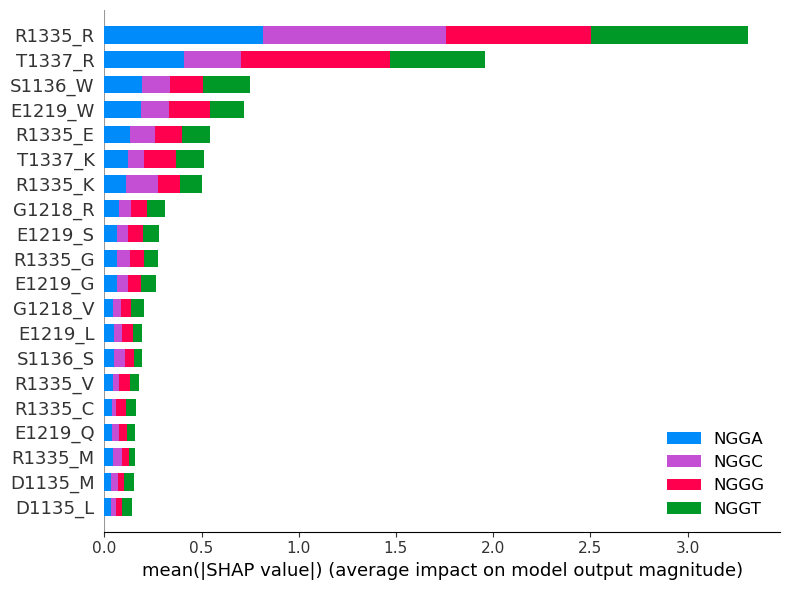

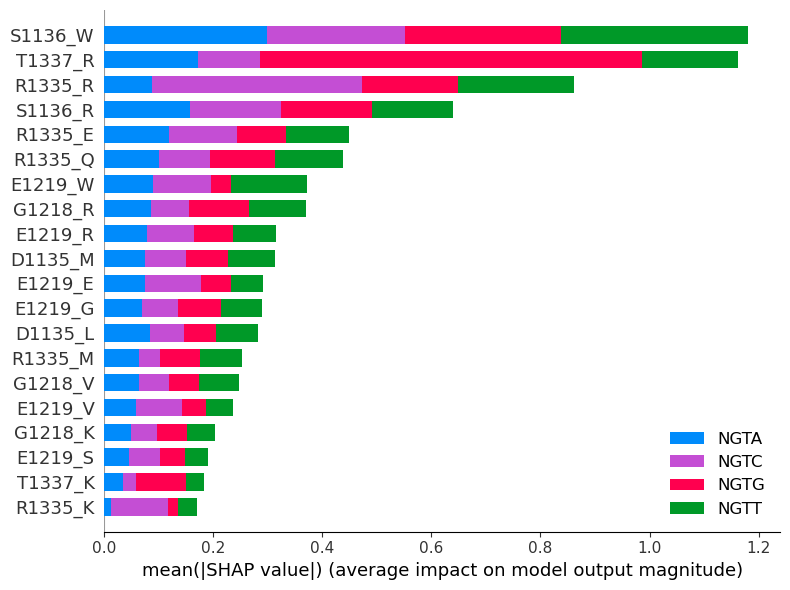

In [4]:

if create_summary_plots:

    shap_values_all = explainer.shap_values(Xsamp)


    for start, stop in [(32, 36), (36, 40), (40, 44), (44, 48)]:
        shap.summary_plot(shap_values_all[start:stop],
                          feature_names = feature_names, 
                          max_display = 20,
                          plot_size=[8,6], 
                          class_names=pams[start:stop],
                          class_inds=range(4))
        
        if save_plots:
            shap.summary_plot(shap_values_all[start:stop],
                              feature_names = feature_names, 
                              max_display = 20,
                              plot_size=[8,6], 
                              class_names=pams[start:stop],
                              class_inds=range(4),
                              show=False)
            p = plt.gcf()
            p.savefig("shap_figs/shap_summary_%s_%s.svg" % (str(start), str(stop)))
            plt.clf()

## Explain activity of "to_explain" variants on PAMs of interest

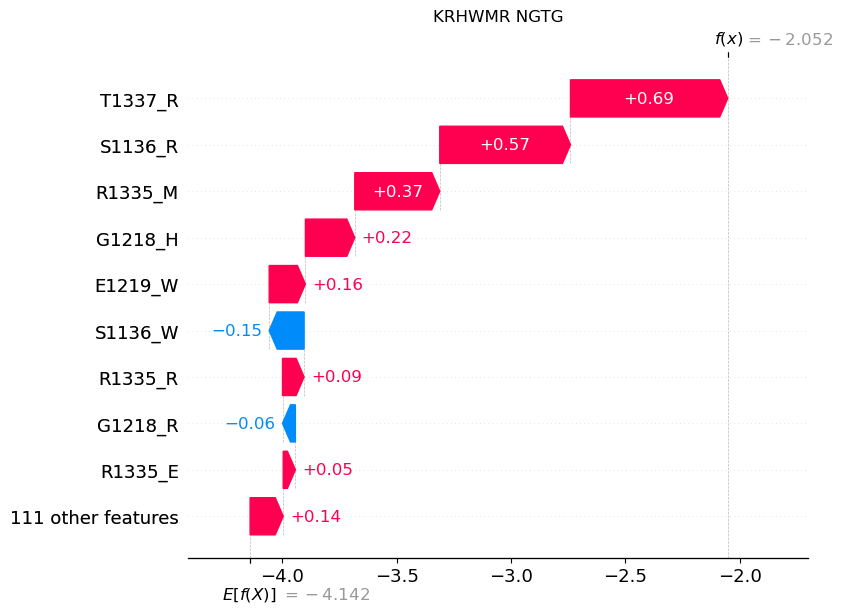

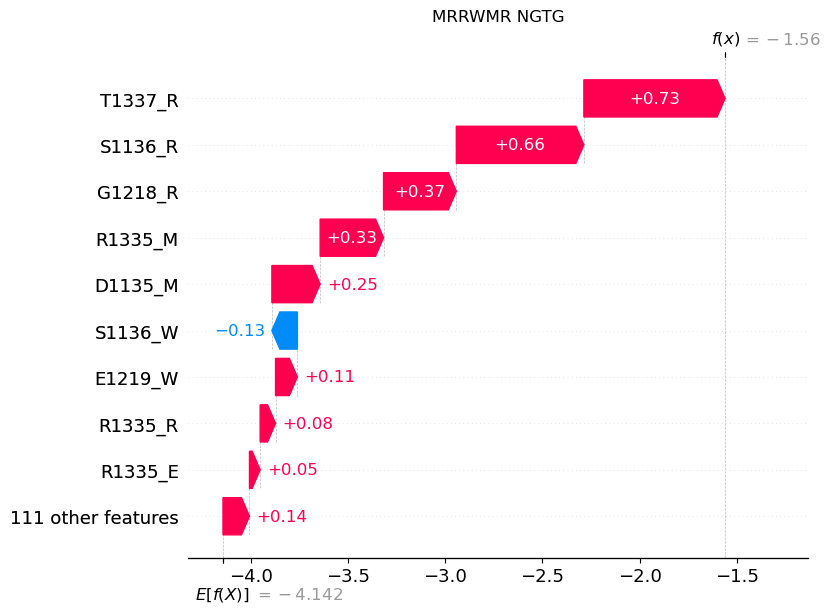

In [5]:
shap_values_to_exp = explainer.shap_values(to_explain)

pam_ind = pams.index(pam_to_explain)

for i in range(len(variants_to_explain)):
    var_name = variants_to_explain[i]
    plt.title(var_name + " " + pam_to_explain)
    shap.plots._waterfall.waterfall_legacy(unnormalize(explainer.expected_value[pam_ind].numpy(), DATA_MEAN, DATA_STD), 
                                           np.multiply(shap_values_to_exp[pam_ind][i], DATA_STD),
                                           feature_names = feature_names, max_display=10)
    if save_plots:
        shap.plots._waterfall.waterfall_legacy(unnormalize(explainer.expected_value[pam_ind].numpy(), DATA_MEAN, DATA_STD), 
                                               np.multiply(shap_values_to_exp[pam_ind][i], DATA_STD),
                                               feature_names = feature_names, max_display=10,
                                               show=False)

        p = plt.gcf()
        p.savefig("shap_figs/%s_%s.svg" % (var_name, pam_to_explain))
        plt.clf()